# Neural Network

In this notebook, we leverage neural networks to uncover the complexities of diabetes diagnosis. Our goal is to build and train a model that predicts diabetes occurrence by analyzing patterns in diagnostic data.

## Importing necessary modules & creating helper functions

In [1]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def split_dataset(df):
    # Convert 'Positive' and 'Negative' labels in the 'class' column to 1 and 0 for binary classification
    df['class'] = df['class'].replace({'Positive': 1, 'Negative': 0})
    X = df.drop(['class'],axis =1)
    y = df['class']

    # Identify columns that contain categorical data  
    objectList = X.select_dtypes(include = "object").columns
    print(objectList)

    # Label ecnoder to convert categorical values to integers 
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    
    # Label encoding to each categorical column
    for feat in objectList:
        X[feat] = le.fit_transform(X[feat].astype(str))

    # Ensure the 'Age' column is of integer type
    X['Age'] = X['Age'].astype(int)
    X= X.values
    y = y.values
     
    # Split the dataset into training and testing sets
    X_train_fresh, X_test_fresh, y_train_fresh, y_test_fresh = train_test_split(X, y, test_size=0.3, random_state=42)


    return X_train_fresh, X_test_fresh, y_train_fresh, y_test_fresh

def preprocess_dataset(df_train, df_test):

    standard_scaler = preprocessing.StandardScaler()
    # Fit the scaler on the training data and transform it to scale the features
    df_train_scaled = standard_scaler.fit_transform(df_train)
    # Apply the same transformation to the test data based on training data statistics
    df_test_scaled = standard_scaler.transform(df_test)

    return df_train_scaled, df_test_scaled

def set_seed(seed = 0):
    '''
    set random seed
    '''
    #Set a random seed for reproducibility of results across multiple function calls
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


# early stopping obtained from tutorial
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False



class CustomDataset(Dataset):
    def __init__(self, feature, output):
        # Convert the input features and labels to PyTorch tensors while ensuring they are the correct type
        self.feature =torch.tensor(feature, dtype=torch.float)
        self.output =torch.tensor(output)
        
    def __len__(self):
        # Returns total number of samples in the dataset
        return len(self.output)
        
    def __getitem__(self,idx):
        # Retrieves the feature and output pair located at the specified index `idx`
        return self.feature[idx], self.output[idx]

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, precision_score, recall_score,f1_score
from sklearn.metrics import classification_report

## Define Model Class

In [3]:
class MLP(nn.Module):

    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        # Define the structure of the neural network
        self.mlp_stack = nn.Sequential(
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(no_hidden,no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(no_hidden,no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(no_hidden,no_labels),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Pass the input through the MLP stack
        logits = self.mlp_stack(x)
        return logits

## Spliting data in 70:30 ratio for training and testing.

In [4]:
def preprocess(df):
    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = split_dataset(df)
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)
    return X_train_scaled, y_train, X_test_scaled, y_test


df = pd.read_csv('cleaned_diabetes_data.csv')

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

Index(['Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss', 'weakness',
       'Polyphagia', 'Genital thrush', 'visual blurring', 'Itching',
       'Irritability', 'delayed healing', 'partial paresis',
       'muscle stiffness', 'Alopecia', 'Obesity'],
      dtype='object')


C:\Users\ryano\AppData\Local\Temp\ipykernel_25668\3417598519.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['class'] = df['class'].replace({'Positive': 1, 'Negative': 0})


## Training Model with 100 epochs

In [5]:
class CustomDataset(Dataset):
    def __init__(self, feature, output):
        # Initializes the dataset with features and labels
        self.feature =torch.tensor(feature, dtype=torch.int32)
        self.output =torch.tensor(output, dtype=torch.int32).unsqueeze(1)
        
    def __len__(self):
        # Returns the total number of samples in the dataset
        return len(self.output)
            
    def __getitem__(self,idx):
        # Retrieves a single sample from the dataset at the specified index
        return self.feature[idx], self.output[idx]


def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):
    # Initializes data loaders for the train and test datasets
    batch_size = 64
    # Create custom dataset instances for train and test sets
    train_dataset = CustomDataset(X_train_scaled, y_train)
    test_dataset = CustomDataset(X_test_scaled, y_test)
    # Create dataloaders for managing batches; shuffling for train set
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)


In [6]:
# Create an instance of the MLP class
model = MLP(16,128,1)
# Set up the optimizer for the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Define the loss function for the model
loss_fn = nn.BCELoss()

In [7]:

class EarlyStopper:
    # Early stopping utility to stop training when validation loss does not improve after a given number of epochs
    def __init__(self, patience=3, min_delta=0.00):
        # Initialize the EarlyStopper
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        # Determine if training should be stopped based on validation loss
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss # Update minimum loss and reset counter if improvement
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
def train_loop(dataloader, model, loss_fn, optimizer):
    # Training loop for one epoch of model training
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.float())
        loss = loss_fn(pred, y.type(torch.float))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predictions = (pred >= 0.5).int()  # Apply threshold 0.5
        correct += (predictions == y).type(torch.float).sum().item()
        
    train_loss /= size
    correct /= size
    return train_loss, correct


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.float())
            test_loss += loss_fn(pred, y.type(torch.float)).item()
            predictions = (pred >= 0.5).int()  # Apply threshold 0.5
            correct += (predictions == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
 
    return test_loss, correct


early_stopper = EarlyStopper(patience=3, min_delta=0.0)
# Initialize lists to track training and testing losses and accuracy
tr_loss, tr_correct = [], []
te_loss, te_correct = [], []
# Set the number of epochs the training process should run
epochs = 100
for epoch in range(epochs):
    train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)
    
    
    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)

    print(f"Epoch {epoch+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")
    # Check if early stopping is triggered due to lack of improvement in train loss
    if early_stopper.early_stop(train_loss): 
        print("Done!")
        break # Exit the training loop if early stopping criteria are met

Epoch 1: Train_accuracy: 59.89%, Train_loss: 0.011040, Test_accuracy: 65.38%, Test_loss: 0.011888
Epoch 2: Train_accuracy: 59.89%, Train_loss: 0.010243, Test_accuracy: 65.38%, Test_loss: 0.010619
Epoch 3: Train_accuracy: 59.89%, Train_loss: 0.009321, Test_accuracy: 65.38%, Test_loss: 0.009060
Epoch 4: Train_accuracy: 68.41%, Train_loss: 0.008084, Test_accuracy: 84.62%, Test_loss: 0.007339
Epoch 5: Train_accuracy: 87.64%, Train_loss: 0.006666, Test_accuracy: 92.95%, Test_loss: 0.005973
Epoch 6: Train_accuracy: 89.01%, Train_loss: 0.005195, Test_accuracy: 92.95%, Test_loss: 0.004853
Epoch 7: Train_accuracy: 92.86%, Train_loss: 0.004166, Test_accuracy: 92.95%, Test_loss: 0.004460
Epoch 8: Train_accuracy: 91.76%, Train_loss: 0.003686, Test_accuracy: 92.31%, Test_loss: 0.004102
Epoch 9: Train_accuracy: 92.58%, Train_loss: 0.003314, Test_accuracy: 92.95%, Test_loss: 0.003568
Epoch 10: Train_accuracy: 93.68%, Train_loss: 0.003261, Test_accuracy: 93.59%, Test_loss: 0.002932
Epoch 11: Train_acc

## Plotting the Loss and accuracy Graph

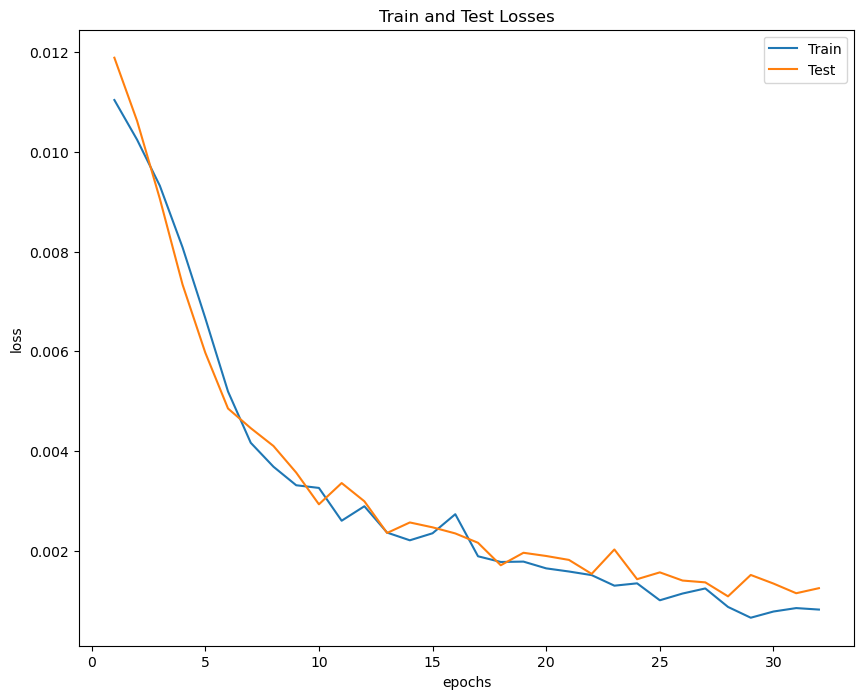

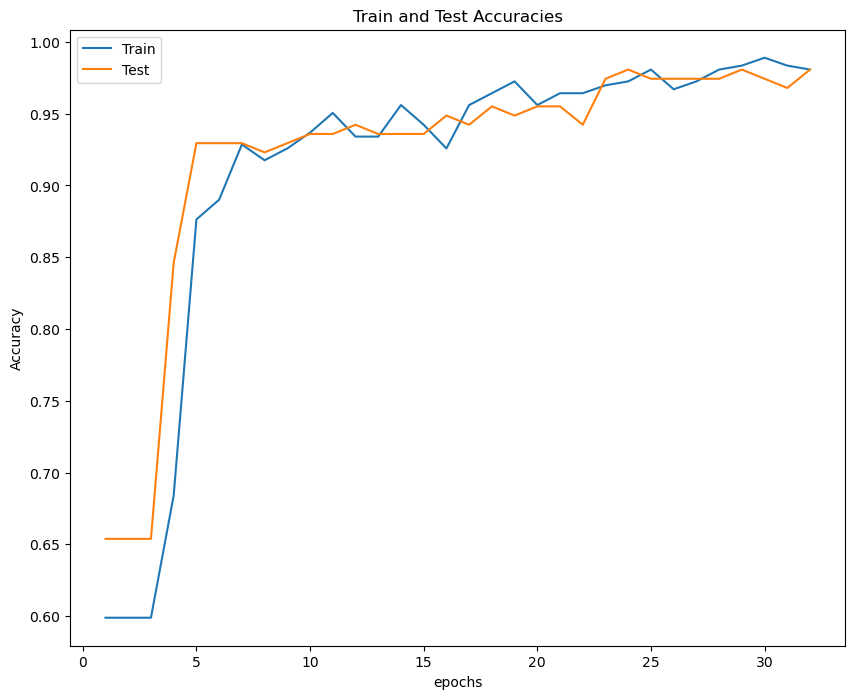

In [8]:

fig = plt.figure(figsize=(10,8))
# Plot training losses
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Train')
# Plot testing losses
plt.plot(range(1,len(te_loss)+1),te_loss,label='Test')

# Labeling the x-axis as 'epochs' and the y-axis as 'loss'
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Train and Test Losses')
plt.show()


fig = plt.figure(figsize=(10,8))
# Plot training losses
plt.plot(range(1,len(tr_correct)+1),tr_correct, label='Train')
# Plot testing losses
plt.plot(range(1,len(te_correct)+1),te_correct,label='Test')

# Labeling the x-axis as 'epochs' and the y-axis as 'Accuracy'
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Test Accuracies')
plt.show()

## Evaluation metrics

In [9]:

import torch
from sklearn.metrics import precision_score, f1_score,recall_score,confusion_matrix



# Assuming you have test_loader and the model is already defined and loaded correctly
# Set the model to evaluation mode
model.eval()

# Collect all predictions and true labels
all_preds = []
all_labels = []
with torch.no_grad():  # Turn off gradients to save memory and computations
    for data, labels in test_dataloader:
        logits = model(data.float())
        predicted_labels = (logits > 0.5).float()  # Applying threshold to get binary class labels
        all_preds.extend(predicted_labels.view(-1).numpy())
        all_labels.extend(labels.numpy())

# Calculate precision,recall and F1 score
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels,all_preds)
f1 = f1_score(all_labels, all_preds)
print("Precision Score:", precision)
print("Recall Score:", recall)
print("F1 Score:", f1)


Precision Score: 0.9900990099009901
Recall Score: 0.9803921568627451
F1 Score: 0.9852216748768472


In [10]:
results_rfc = pd.DataFrame([['Multi-Layer Perception', test_correct, precision,recall,f1]], columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
results_rfc

,Model,Accuracy,Precision,Recall,F1 Score
0,Multi-Layer Perception,0.980769,0.990099,0.980392,0.985222


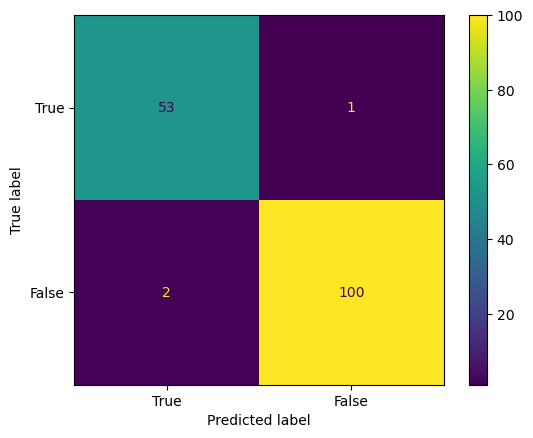

In [11]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(all_labels, all_preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['True', 'False'])

cm_display.plot()
plt.show()

## Conclusion

After training our neural network, we've gained valuable insights into diabetes diagnostics. Our neural network achieved an impressive test accuracy of 98.1%, substantiating its efficacy in predicting diabetes.

A closer look at the precision and recall scores, 99.0% and 98.0%, respectively, reveals a high degree of trustworthiness in the model's predictive capabilities for both classes. The F1 Score, recorded at 98.5% further endorses the model's precision and its capacity to discriminate effectively between outcomes.

With robustness and precision, our neural network model stands as a promising asset for medical professionals, offering a high-confidence tool for diabetes diagnosis.